In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# label

In [21]:
labels = {
    '0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {
    '0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', 
    '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [2]:
X = []
y = []

print("Opening dataset...")
try:
    with open("data_msg_type/semantic_sim.txt", 'rU') as f:
        res = list(f)
        for line in res:
            line.strip("\n")
            features = line.split("\t")
            while features.__contains__(""):
                features.remove("")
            for i in range(len(features)):
                features[i] = float(features[i])
            X.append(features)
         
    #read the classes from file and put them in list.      
    with open("data_msg_type/semantic_label_index.txt", 'rU') as f:
        res = list(f)
        for line in res:
            y.append(int(line.strip("\n")[0]))
            
except:
    print("Error in reading the train set file.")
    exit()

print("Dataset loaded.")

Opening dataset...
Dataset loaded.


# split data

In [3]:
X = np.array(X) #change to matrix
y = np.array(y) #change to matrix (sklearn models only accept matrices)

print("Separating data into 80% training set & 20% test set...")
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.20, random_state=33)#random split.
print("Dataset separated.\n")

Separating data into 80% training set & 20% test set...
Dataset separated.



# random forest train

In [9]:
print("---------------Random Forest---------------")
n_estimators_list = range(1, 13) #try from one to 21 estimators.
result_random_forests = [] #to be used later for comparing rf with different estimators.
max_score_rf = float("-inf") #just in case we get NaN
best_param_rf = None

for trees in n_estimators_list:
    print("Testing %d trees" % trees)
    rf_clf = RandomForestClassifier(
        n_estimators=trees, max_depth=None, min_samples_split=2, random_state=0)
    scores = cross_validation.cross_val_score(
        rf_clf, X_train, y_train, scoring="accuracy", cv=14)
    result_random_forests.append(scores.mean())
    if scores.mean() > max_score_rf:
        max_score_rf = scores.mean()
        best_param_rf = {"n_estimators": trees}

---------------Random Forest---------------
Testing 1 trees
Testing 2 trees
Testing 3 trees
Testing 4 trees
Testing 5 trees
Testing 6 trees
Testing 7 trees
Testing 8 trees
Testing 9 trees
Testing 10 trees
Testing 11 trees
Testing 12 trees


# test and predict

In [11]:
rf_clf = RandomForestClassifier(n_estimators=best_param_rf.get("n_estimators"), 
                    max_depth=None, min_samples_split=2, random_state=0).fit(X_train, y_train)

rf_clf_test_score = rf_clf.score(X_test, y_test)

# save trained model for future use.
#joblib.dump(rf_clf,'data/rf_clf.pkl', compress=9)

count1 = 0
count2 = 0
actualist = []
predlist = []

for i in range(len(X_test)):
    count2 += 1
    classinrow = X_test[i]
    classinrow = np.array(X_test[i]).reshape(1,-1)
    # each xval is a set of features la one sample.
    # predict class for each row.. each i is a row.
    predicted = rf_clf.predict(classinrow)
    actual = y_test[i]
    actualist.append(actual)
    predlist.append(predicted[0])
    if predicted == actual:
        count1 += 1
print()
print("Number of trees in forest: ", len(n_estimators_list))
print("Results: ", result_random_forests)
print("Best accuracy: ", max_score_rf)
print("Best parameter: ", best_param_rf)
print("Test set accuracy: ", rf_clf_test_score)

print("Total cases: ", count2)
print("Correct Prediction: ", count1)
print("Correct prediction rate: ", float(count1) / count2)

()
('Number of trees in forest: ', 12)
('Results: ', [0.9972124234964922, 0.9972998687875928, 0.99786246267037959, 0.99812496711099574, 0.99808738865461621, 0.99817495648787347, 0.99826247181584737, 0.99824993400379713, 0.99831248744688872, 0.99839997214220433, 0.99838748683235568, 0.99843748058696513])
('Best accuracy: ', 0.99843748058696513)
('Best parameter: ', {'n_estimators': 12})
('Test set accuracy: ', 0.99875000000000003)
('Total cases: ', 20000)
('Correct Prediction: ', 19975)
('Correct prediction rate: ', 0.99875)


# plot

               precision    recall  f1-score   support

      network       1.00      0.97      0.99        36
         file       0.99      1.00      1.00      2565
     database       1.00      1.00      1.00       506
      service       1.00      1.00      1.00         1
       memory       1.00      1.00      1.00      2429
communication       1.00      0.99      1.00       961
       others       1.00      1.00      1.00     12456
     security       0.99      0.99      0.99       595
         disk       1.00      1.00      1.00       422
    processor       1.00      1.00      1.00        29

  avg / total       1.00      1.00      1.00     20000

[[   35     1     0     0     0     0     0     0     0     0]
 [    0  2558     0     0     0     3     1     3     0     0]
 [    0     0   506     0     0     0     0     0     0     0]
 [    0     0     0     1     0     0     0     0     0     0]
 [    0     2     0     0  2427     0     0     0     0     0]
 [    0     3     0   

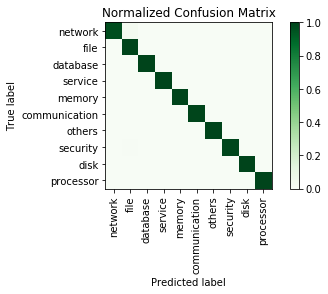

In [22]:
# cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

print(metrics.classification_report(
    actualist, predlist, target_names = list(fault_label.values())))
cm = metrics.confusion_matrix(actualist, predlist)
print(cm)

# show a normalized matrix as a separate figure.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)